# LSTM model for stock prediction


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW
# from keras.regularizers import l2

## Data Reading

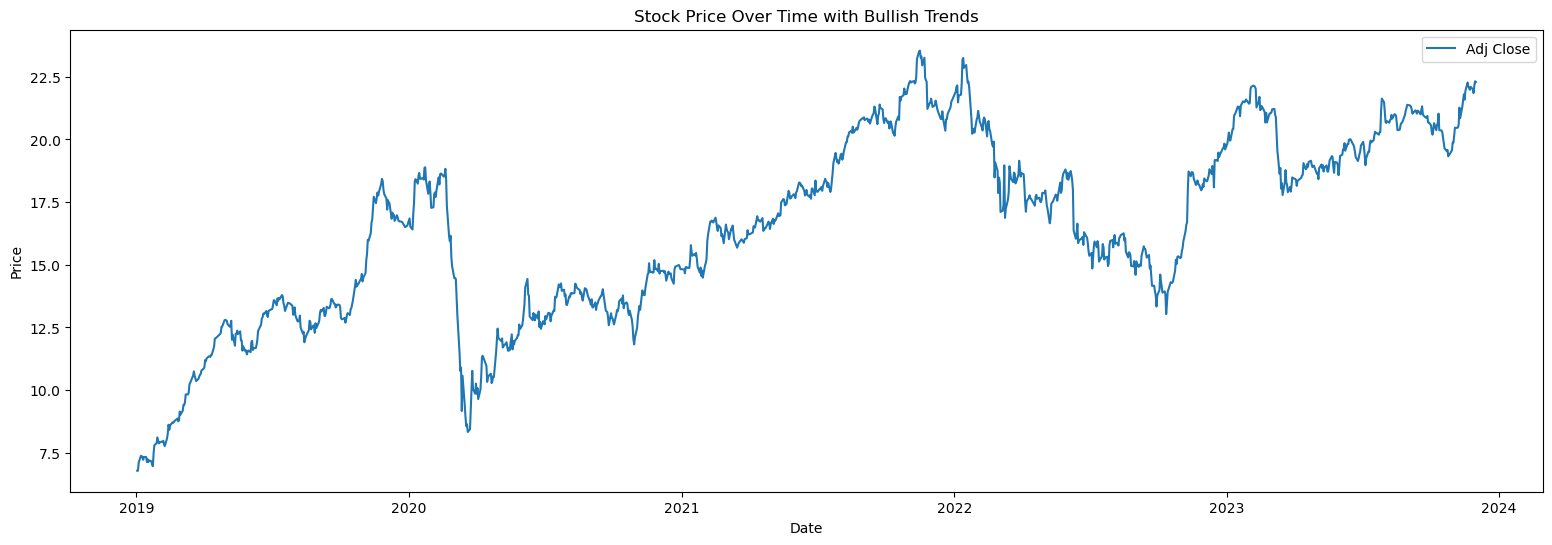

Trading Days shape: (1255, 6)
Columns: ['Adj Close', 'Open', 'High', 'Low', 'Close', 'Volume']


In [35]:
start = "2019-01-01"
end = "2023-12-01"
target_column_name = 'Adj Close'

data = pd.read_csv('./data/AZM.MI.csv', index_col=0, parse_dates=True).loc[start:end]
data.dropna(inplace=True)
cols = [target_column_name] + [ col for col in data if col != target_column_name]

target_column = list(data.columns).index(target_column_name)
data = data[cols]

plt.figure(figsize=(19, 6))
plt.plot(data[target_column_name], label=target_column_name)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock Price Over Time with Bullish Trends')
plt.legend()
plt.show()

print(f"Trading Days shape: {data.shape}")
print(f'Columns: {cols}')

## Data refactoring

In [36]:
# Feature array and target array
data_array = np.array(data.values)
target_array = np.array(data[target_column_name].values).reshape(-1, 1)

# Normalize the data
scaler_data = MinMaxScaler()
scaler_data.fit(data_array)
data_array = scaler_data.transform(data_array)

scaler_target = MinMaxScaler()
scaler_target.fit(target_array)
target_array = scaler_target.transform(target_array)

# Create the sequences
SEQUENCE_LENGTH = 100

def create_sequences(data, target, seq_length):
    sequence_data = []
    sequence_target = []
    for i in range(seq_length, len(data)):
        sequence_data.append(data[i-seq_length:i])
        sequence_target.append(target[i])
    return np.array(sequence_data), np.array(sequence_target)

data_sequences, target_sequences = create_sequences(data_array, target_array, SEQUENCE_LENGTH)

# Split the data: train (+ validation) and test datasets. 
train_size = int(len(data_array) * 0.85)

train_data, test_data = data_sequences[:train_size], data_sequences[train_size:]
train_target, test_target = target_sequences[:train_size], target_sequences[train_size:]

# ! Check the shapes
print(f'train_data: {train_data.shape} triat_target: {train_target.shape}')
print(f'test_data: {test_data.shape} test_target: {test_target.shape}')

# Test correctness of the sequences generated against the .csv data
# test_index = 0
# test_column_prompt = 0
# a = scaler_data.inverse_transform(data_sequences[test_index])
# b = scaler_target.inverse_transform(target_sequences)

# for i in range (0, SEQUENCE_LENGTH):
#     print(f"A[{i}]: {a[i][test_column_prompt]}")

# print(f'b: {b[test_index]}')

train_data: (1066, 100, 6) triat_target: (1066, 1)
test_data: (89, 100, 6) test_target: (89, 1)


## Model Definition

In [46]:
input_shape=(train_data.shape[1], train_data.shape[2])

def early_stopping(patience):
    return EarlyStopping(
        monitor='val_loss',
        patience=patience,
        verbose=2,
        mode='min',
        restore_best_weights=True,
    )

def lstm_build():
    # l2_value = 0.0003
    model = Sequential([
        Input(shape=(input_shape)),
        Bidirectional(
            LSTM(128, return_sequences=False,
                # recurrent_regularizer=l2(l2_value),
                # bias_regularizer=l2(l2_value),
                # kernel_regularizer=l2(l2_value)
            )
        ),
        Dropout(0.2),
        Dense(units=1)
    ])
    return model

def lstm_train(model, X_train, y_train, epochs=100, batch_size=128, patience=5):
    model.compile(
        optimizer=AdamW(),
        loss='mean_absolute_error'
    )
    model.fit(X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            shuffle =True,
            validation_split=0.3, # Validation dataset
            callbacks=[early_stopping(patience)]
    )

In [ ]:
patience = 50
epochs = 1000
batch_size = 1024

lstm_model = lstm_build()
lstm_train(lstm_model,
            train_data, train_target,
            epochs = epochs,
            batch_size = batch_size,
            patience = patience)

## Evaluation
### Evaluation functions:

In [48]:
def plot_results(price_actual_array, price_predicted_array, target_column_name, title="Actual vs Predicted"):
    plt.figure(figsize=(15, 6))
    plt.plot(price_actual_array, label="Actual Price", color='blue')
    plt.plot(price_predicted_array, label="Predicted Price", color='red', linestyle='dashed')
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel(target_column_name)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.show()
    
def evaluate_price_predictions(price_actual_array, price_predicted_array):
    """ 
    Evaluation function: given two arrays, one for the price prediction and one for the actual price,
    evaluates the performance using various metrics.
    """
    price_actual_array = np.array(price_actual_array)
    price_predicted_array = np.array(price_predicted_array)
    
    mae = np.mean(np.abs(price_predicted_array - price_actual_array))
    mse = np.mean((price_predicted_array - price_actual_array)**2)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((price_actual_array - price_predicted_array) / price_actual_array)) * 100
    sst = np.sum((price_actual_array - np.mean(price_actual_array))**2)
    ssr = np.sum((price_actual_array - price_predicted_array)**2)
    r_squared = 1 - (ssr/sst)

    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
    print(f"R-squared (R²): {r_squared:.2f}")

### Training and validation data

34/34 [==============================] - 0s 5ms/step
Mean Absolute Error (MAE): 0.30
Mean Squared Error (MSE): 0.17
Root Mean Squared Error (RMSE): 0.41
Mean Absolute Percentage Error (MAPE): 1.85%
R-squared (R²): 0.98


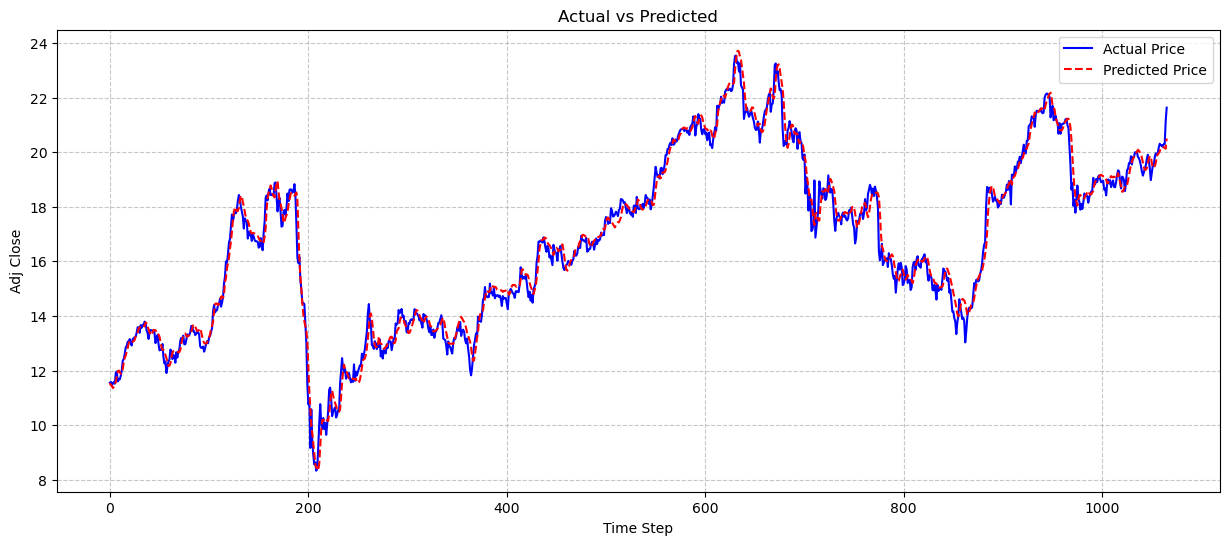

In [49]:
lstm_model.evaluate(train_data, train_target)

# denormalization
price_predicted_array = scaler_target.inverse_transform(lstm_model.predict(train_data).reshape(-1, 1))
price_actual_array = scaler_target.inverse_transform(train_target).flatten()

# evaluation
evaluate_price_predictions(price_predicted_array.flatten(), price_actual_array.flatten())

# plotting
plot_results(price_actual_array, price_predicted_array, target_column_name)

### Test Data

3/3 [==============================] - 0s 5ms/step
Mean Absolute Error (MAE): 0.24
Mean Squared Error (MSE): 0.09
Root Mean Squared Error (RMSE): 0.31
Mean Absolute Percentage Error (MAPE): 1.17%
R-squared (R²): 0.78


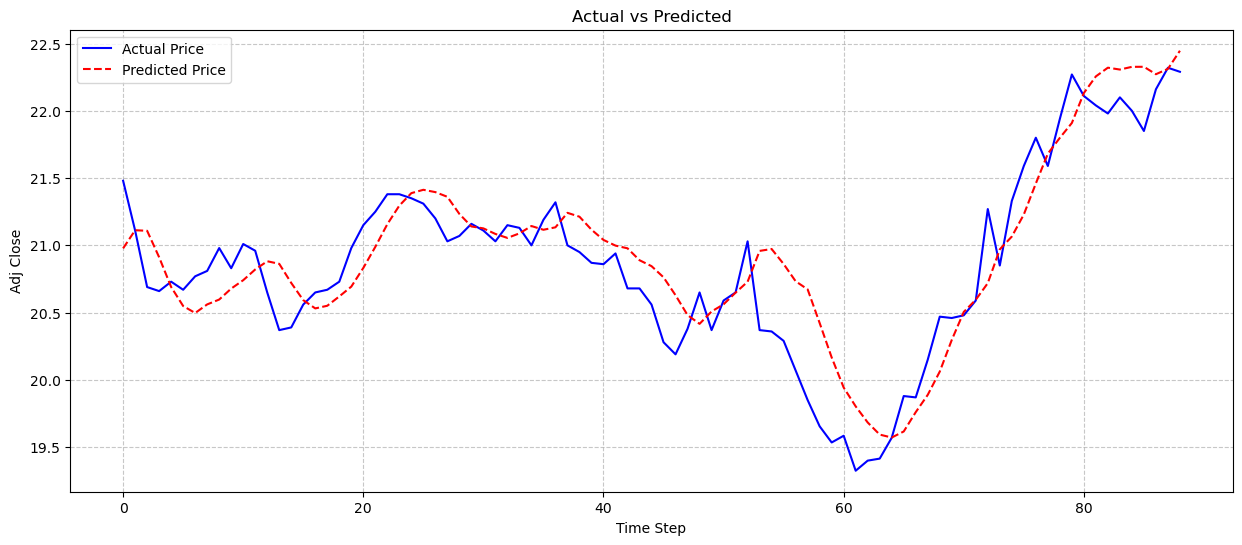

In [50]:
lstm_model.evaluate(test_data, test_target)

# denormalization
price_predicted_array = scaler_target.inverse_transform(lstm_model.predict(test_data).reshape(-1, 1))
price_actual_array = scaler_target.inverse_transform(test_target).flatten()

# evaluation
evaluate_price_predictions(price_predicted_array.flatten(), price_actual_array.flatten())

# plotting
plot_results(price_actual_array, price_predicted_array, target_column_name)